In [1]:
import sys
sys.path.append("..")

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim

import mbrl.mbpo as mbpo
import mbrl.replay_buffer as replay_buffer

device = torch.device("cuda:0")

%load_ext autoreload
%autoreload 2

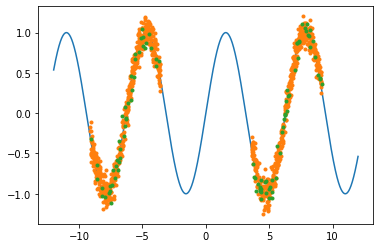

In [2]:
x_data = np.linspace(-12, 12, 10000)
y_data = np.sin(x_data)

train_val_size = 1100
train_size = 1000
train_val_idx = np.random.choice(list(range(1200, 3500)) + list(range(6500, 8800)), size=train_val_size, replace=False)
x_train = x_data[train_val_idx[:train_size]]
y_train = y_data[train_val_idx[:train_size]] + 0.1 * np.random.randn(train_size)
x_val = x_data[train_val_idx[train_size:]]
y_val = y_data[train_val_idx[train_size:]] + 0.1 * np.random.randn(train_val_size - train_size)

plt.plot(x_data, y_data, x_train, y_train, '.', x_val, y_val, '.')
plt.show()

In [3]:
num_members = 5
dataset_train = replay_buffer.BootstrapReplayBuffer(train_size, 256, num_members, (1,), (0,))
for i in range(train_size):
    dataset_train.add(x_train[i], 0, y_train[i], 0, False)

In [4]:
dataset_val = replay_buffer.IterableReplayBuffer(train_val_size - train_size, 256, (1,), (0,))
for i in range(train_val_size - train_size):
    dataset_val.add(x_val[i], 0, y_val[i], 0, False)

In [5]:
num_members = 5
ensemble = [mbpo.GaussianMLP(1, 2, 2, 10).to(device) for _ in range(num_members)]
optimizers = [optim.Adam(ensemble[i].parameters(), lr=0.01) for i in range(num_members)]

best_weights found at epoch 0. Val loss:  0.303
best_weights found at epoch 1. Val loss:  0.301
best_weights found at epoch 2. Val loss:  0.284
best_weights found at epoch 4. Val loss:  0.272
best_weights found at epoch 5. Val loss:  0.270
best_weights found at epoch 6. Val loss:  0.267
best_weights found at epoch 7. Val loss:  0.261
best_weights found at epoch 8. Val loss:  0.260
best_weights found at epoch 9. Val loss:  0.258
best_weights found at epoch 13. Val loss:  0.253
best_weights found at epoch 14. Val loss:  0.252
best_weights found at epoch 17. Val loss:  0.251
best_weights found at epoch 18. Val loss:  0.251
best_weights found at epoch 19. Val loss:  0.249
best_weights found at epoch 20. Val loss:  0.245
best_weights found at epoch 26. Val loss:  0.239
best_weights found at epoch 27. Val loss:  0.236
best_weights found at epoch 29. Val loss:  0.234
best_weights found at epoch 31. Val loss:  0.231
best_weights found at epoch 45. Val loss:  0.229
best_weights found at epoch 4

best_weights found at epoch 705. Val loss:  0.021
best_weights found at epoch 715. Val loss:  0.021
best_weights found at epoch 718. Val loss:  0.021
best_weights found at epoch 722. Val loss:  0.020
best_weights found at epoch 727. Val loss:  0.019
best_weights found at epoch 732. Val loss:  0.019
best_weights found at epoch 736. Val loss:  0.019
best_weights found at epoch 737. Val loss:  0.019
best_weights found at epoch 774. Val loss:  0.018
best_weights found at epoch 780. Val loss:  0.018
best_weights found at epoch 796. Val loss:  0.018
best_weights found at epoch 824. Val loss:  0.017
best_weights found at epoch 825. Val loss:  0.017
best_weights found at epoch 839. Val loss:  0.017
best_weights found at epoch 842. Val loss:  0.017
best_weights found at epoch 906. Val loss:  0.016
best_weights found at epoch 920. Val loss:  0.016
best_weights found at epoch 921. Val loss:  0.016
best_weights found at epoch 924. Val loss:  0.016
best_weights found at epoch 1014. Val loss:  0.015

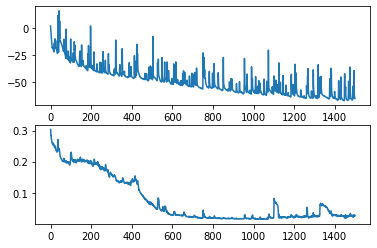

In [6]:
train_losses, val_losses = mbpo.train_dyn_ensemble(
    ensemble, optimizers, dataset_train, device, dataset_val=dataset_val, num_epochs=1500, patience=1500)
fig, ax = plt.subplots(2, 1)
ax[0].plot(train_losses)
ax[1].plot(val_losses)
plt.show()

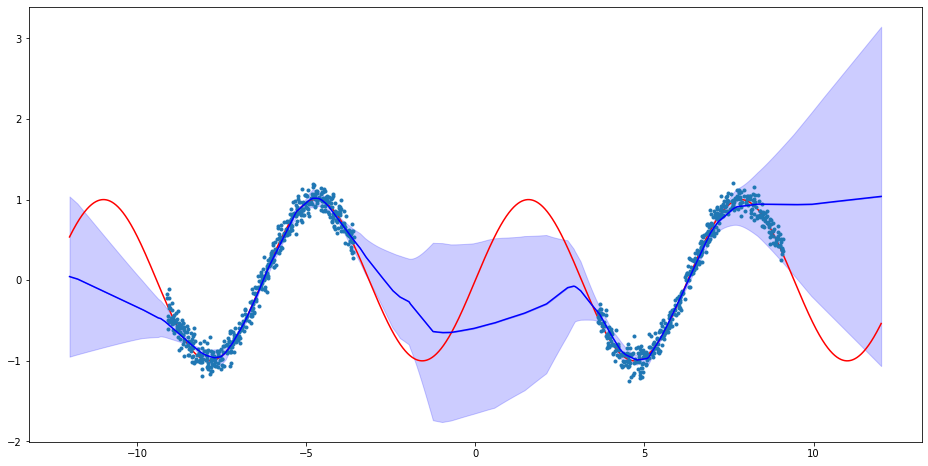

In [7]:
x_tensor = torch.from_numpy(x_data).unsqueeze(1).float().to(device)

y_mean = np.zeros_like(y_data)
for i in range(num_members):
    net = ensemble[i]
    pred = net(x_tensor)
    y_pred = pred[0][:, 0].squeeze().detach().cpu().numpy()
    y_mean += y_pred
y_mean /= num_members

y_std = np.zeros_like(y_data)
for i in range(num_members):
    net = ensemble[i]
    pred = net(x_tensor)
    y_pred = pred[0][:, 0].squeeze().detach().cpu().numpy()
    y_std += (y_pred - y_mean) ** 2
y_std /= (num_members - 1)
y_std = np.sqrt(y_std)
    
plt.figure(figsize=(16, 8))
plt.plot(x_data, y_data, 'r', x_train, y_train, '.', x_data, y_mean, 'b')
plt.fill_between(x_data, y_mean, y_mean + y_std, color='b', alpha=0.2)
plt.fill_between(x_data, y_mean - y_std, y_mean, color='b', alpha=0.2)
plt.show()